In [1]:
import json
import os
from sympy import symbols, simplify, sin, expand
#from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

/home/paolo/.conda/envs/pymc_env/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import pymc as pm
import arviz as az

In [3]:
x = np.linspace(-2, 2, 500)
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
noise = rng.normal(size=x.shape)
y = np.cos(x) + noise 

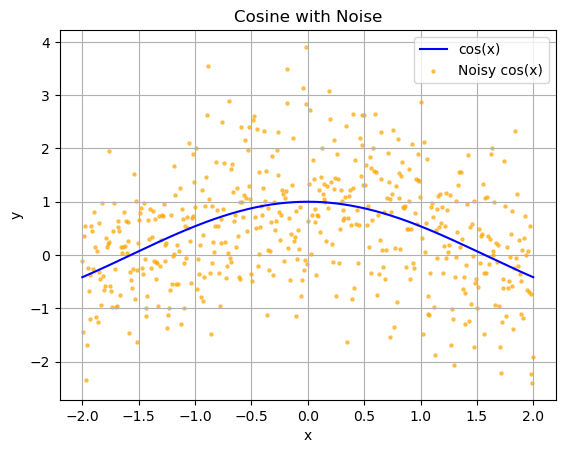

In [4]:
plt.plot(x, np.cos(x), label='cos(x)', color='blue')
plt.scatter(x, y, s=5, alpha=0.6, label='Noisy cos(x)', color='orange')
plt.legend()
plt.title('Cosine with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [6]:
# Save to CSV in a format SISSO++ expects
df = pd.DataFrame({"sample_id": [f"s{i+1}" for i in range(len(x))], 'f1': x, 'target': y})
df.to_csv("/home/paolo/Thesis/Test_uncertainty/data/cosine_data.csv", index=False)
data_file = "/home/paolo/Thesis/Test_uncertainty/data/cosine_data.csv"

os.environ["SISSOPP_TUT_DAT_FILE"] = data_file

In [ ]:
# Try the fit with the exact functional form
cos_json = {
    'data_file': data_file,
     'property_key': 'target',
     'desc_dim': 1,
     'n_sis_select': 10,
     'max_rung': 2,
     'calc_type': 'regression',
     'min_abs_feat_val': 1e-05,
     'max_abs_feat_val': 1e8,
     'n_residual': 10,
     'n_models_store': 10,
     'leave_out_frac': 0.0,
     'leave_out_inds': [],
     'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
}
json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [ ]:
# # Try the fit with the exact functional form
# cos_json = {
#     'data_file': data_file,
#      'property_key': 'target',
#      'desc_dim': 1,
#      'n_sis_select': 10,
#      'max_rung': 2,
#      'calc_type': 'regression',
#      'min_abs_feat_val': 1e-05,
#      'max_abs_feat_val': 1e8,
#      'n_residual': 10,
#      'n_models_store': 10,
#      'leave_out_frac': 0.0,
#      'leave_out_inds': [],
#      'opset': ['add', 'sub', 'mult', 'div', 'cos', 'sin', 'sqrt', 'sq']
# }
# json.dump(cos_json, open("/home/paolo/Thesis/Test_uncertainty/data/cos.json", "w"), indent=4)

In [5]:
# Extract the formulas and the values of the parameters from the SISSO output
formulas = []
a0_list = []
c0_list = []
models_stored = 10
for i in range(models_stored):
    filename = f'./models_cosine/train_dim_1_model_{i}.dat'
    with open(filename, 'r') as f:
        line1 = next(f)               # First line
        for _ in range(4): next(f)    # Skip lines 2 to 5
        line6 = next(f)               # Sixth line
        formula = line1.replace('#', '').strip()
        # Split line6 by spaces
        parts = line6.strip().split()
        a0_i = parts[3].rstrip(',')
        c0_i = parts[4].rstrip(',')

        formulas.append(formula)
        a0_list.append(a0_i)
        c0_list.append(c0_i)
        print(formula, a0_i, c0_i)

c0 + a0 * cos(f1) 1.026516626042362e+00 -2.513565483497359e-02
c0 + a0 * (sin(f1) / f1) 2.722430765680743e+00 -1.743636004010924e+00
c0 + a0 * (sin(f1) * f1) -7.192705739146151e-01 1.067479753468510e+00
c0 + a0 * (cos(f1) - (f1^2)) 2.777296467752327e-01 6.857838707456738e-01
c0 + a0 * (f1^2) -3.797943293052196e-01 9.482006102788901e-01
c0 + a0 * (cos(f1) + (f1^2)) -5.976215092714716e-01 1.510466509322255e+00
c0 + a0 * cos((f1^2)) 5.750589227309285e-01 3.081072596264779e-01
c0 + a0 * (sin(f1)^2) -1.167218004837731e+00 1.134346477826760e+00
c0 + a0 * ((f1^2)^2) -9.712679781678096e-02 7.530790459783490e-01
c0 + a0 * (sin(f1) - (f1^2)) 2.763907975739480e-01 8.097766439532607e-01


In [6]:
# Store the numerical values of the parameters into np arrays
a0 = np.array(a0_list, dtype=float)
c0 = np.array(c0_list, dtype=float)
a0, c0

(array([ 1.02651663,  2.72243077, -0.71927057,  0.27772965, -0.37979433,
        -0.59762151,  0.57505892, -1.167218  , -0.0971268 ,  0.2763908 ]),
 array([-0.02513565, -1.743636  ,  1.06747975,  0.68578387,  0.94820061,
         1.51046651,  0.30810726,  1.13434648,  0.75307905,  0.80977664]))

In [7]:
a0_simb, c0_simb, x_simb = sp.symbols('a0 c0 f1')
symbol_map = {'x': x_simb, 'a0': a0_simb, 'c0': c0_simb}

# Converts the equtions (stored into the 'Feature Expression' column of df) from strings into sympy objects
sympy_exprs = [sp.sympify(f, locals=symbol_map) for f in formulas]
# Builds Python functions starting from the sympy expressions pruning the constants
functions = [sp.lambdify((x_simb), (expr - c0_simb)/a0_simb, modules='numpy') for expr in sympy_exprs]

In [8]:
sympy_exprs

[a0*cos(f1) + c0,
 a0*sin(f1)/f1 + c0,
 a0*f1*sin(f1) + c0,
 a0*(-f1**2 + cos(f1)) + c0,
 a0*f1**2 + c0,
 a0*(f1**2 + cos(f1)) + c0,
 a0*cos(f1**2) + c0,
 a0*sin(f1)**2 + c0,
 a0*f1**4 + c0,
 a0*(-f1**2 + sin(f1)) + c0]

In [9]:
for expr in sympy_exprs:
    print(sp.simplify((expr - c0_simb)/a0_simb))

cos(f1)
sin(f1)/f1
f1*sin(f1)
-f1**2 + cos(f1)
f1**2
f1**2 + cos(f1)
cos(f1**2)
sin(f1)**2
f1**4
-f1**2 + sin(f1)


In [10]:
# In each column are stacked data for each of the 10 different formulas
Phi = np.column_stack([f(x) for f in functions])
n_features = Phi[:,0].shape
n_features

(500,)

In [11]:
# basic_model = pm.Model()

# with basic_model:
#     # Priors for unknown model parameters
#     # Normal weights
#     alpha = pm.Normal("c0", mu=c0[3], sigma=10)
#     beta = pm.Normal("a0", mu=a0[3], sigma=10)
#     # Sigma is positively defined and normally distributed --> HalfNormal
#     sigma = pm.HalfNormal("sigma", sigma=1)

#     # Expected value of outcome, Linear model
#     mu = alpha + beta * Phi[:, 3]

#     # Likelihood (sampling distribution) of observations --> normal distribution with the deterministic equation as mean and sigma as variance
#     y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
#     # draws 2000 posterior samples from the unnormalized posterior distribution computed as likelihood x prior using sequential montecarlo method
#     idata = pm.smc.sample_smc()
#     # idata = pm.sample()

In [11]:
traces = []
for i in range(models_stored):
    with pm.Model() as model:
        # Select the i-th column
        f = Phi[:, i]

        # Priors, Che valori di sigma potrei usare? 10 forse è un po' troppo
        c0_coeff = pm.Normal("c0", mu=c0[i], sigma=10)
        a0_coeff = pm.Normal("a0", mu=a0[i], sigma=10)
        sigma = pm.HalfNormal("sigma", sigma=2)

        # Linear parametrization
        mu = c0_coeff + a0_coeff * f

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sample from posterior
        # Sequential montecarlo chiedi spiegazione
        trace = pm.smc.sample_smc()
        #trace = pm.sample()
        traces.append(trace)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

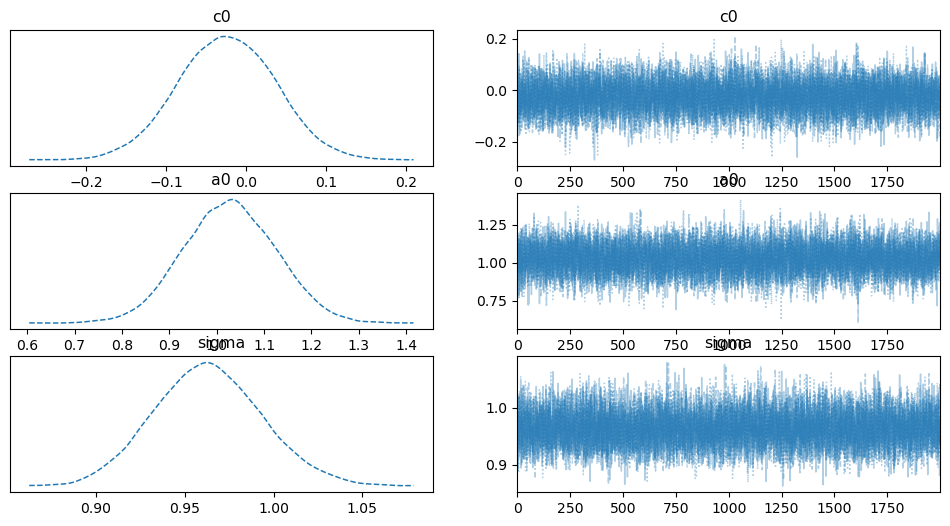

In [12]:
az.plot_trace(traces[0], combined=True);

In [13]:
az.summary(traces[0], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,-0.02,0.06,-0.14,0.09,0.0,0.0,11907.29,11856.96,1.0
a0,1.03,0.10,0.85,1.21,0.0,0.0,12055.36,12013.29,1.0
sigma,0.96,0.03,0.91,1.02,0.0,0.0,11818.34,11670.24,1.0


In [15]:
c0[0], a0[0]

(np.float64(-0.02513565483497359), np.float64(1.026516626042362))

We have used Sequential MonteCarlo as a sampling technique since it is able to provide us a robust estimate of the evidence, also called marginal likelihood.
In Bayes' formula:
$$
    p(\theta | D) = \frac{p(D|\theta) \ p(\theta)}{p(D)}
$$
where the evidence is defined as $p(D) = \int d\theta \ p(d|\theta) p(\theta)$, obtained marginalizing the likelihood thus the name.

Actually for numerical reasons the returned value is the log marginal likelihood (this helps to avoid underflow), we thus need to exponentiate to get the marginal likelihood.

In [14]:
traces[i].sample_stats["log_marginal_likelihood"]

<xarray.DataArray 'log_marginal_likelihood' (chain: 6, draw: 11)> Size: 528B
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-717.984926865276)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-717.9519077696585)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-717.915886193316)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-717.9442578725901)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-717.8252404741686)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-718.1321803089534)]], dtype=object)
Coordinates:
  * chain    (chain) int64 48B 0 1 2 3 4 5
  * draw     (draw) int64 88B 0 1 2 3 4 5 6 7 8 9 10

In [15]:
# log marginal likelihood for model 0: 6 chains and 11 draws per chain
traces[0].sample_stats["log_marginal_likelihood"].values 

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-702.2303774022059)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-702.2188849633458)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-702.1614618355878)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-702.2530857765546)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-702.1926707833028)],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-702.1647270331414)]], dtype=object)

In [16]:
marginal_likelihoods = []
log_marginal_likelihoods = []
for i in range(models_stored):
    log_ml_raw = traces[i].sample_stats["log_marginal_likelihood"].values
    # Flatten possible nested lists and cast to floats
    flattened = []
    for row in log_ml_raw.ravel():
        # If it’s a list, tuple, or NumPy array then flattened.extend(row) appends all items inside it (not the list itself).
        if isinstance(row, (list, tuple, np.ndarray)):
            flattened.extend(row)
        # Otherwise (a plain number or NaN) then flattened.append(row) just adds the single value.
        else:
            flattened.append(row)
    # This ensures that everything inside flattened is a single scalar number, not a list or array.
    log_ml = np.array(flattened, dtype=float)
    # Checks that the entry is effectively a number
    log_ml = log_ml[~np.isnan(log_ml)]
    # Computes the mean
    mean_log_ml = np.mean(log_ml)
    # Exponentiate to find out the marginal likelihood and appends to the list
    marginal_likelihoods.append(np.exp(mean_log_ml))
    log_marginal_likelihoods.append(mean_log_ml)

In [17]:
marginal_likelihoods

[np.float64(1.088628591158529e-305),
 np.float64(2.1275706686258724e-305),
 np.float64(4.9600421871686667e-306),
 np.float64(1.621624215626602e-306),
 np.float64(1.4979381641911277e-306),
 np.float64(8.139153887885899e-307),
 np.float64(9.551096920220423e-308),
 np.float64(3.17226760279283e-309),
 np.float64(7.820011999513e-311),
 np.float64(1.564368821167e-312)]

In [18]:
log_marginal_likelihoods

[np.float64(-702.2035346323564),
 np.float64(-701.5334725655248),
 np.float64(-702.9896242099998),
 np.float64(-704.107610206965),
 np.float64(-704.1869488508461),
 np.float64(-704.7969373195374),
 np.float64(-706.9395526335134),
 np.float64(-710.3443470708877),
 np.float64(-714.0472778321276),
 np.float64(-717.9590665806604)]

In [59]:
marginal_likelihoods[2] == np.exp(traces[2].sample_stats["log_marginal_likelihood"].mean())

<xarray.DataArray 'log_marginal_likelihood' ()> Size: 1B
array(True)

In [19]:
# Recovers the highest ml value and its related index, i.e. model
max_ml = np.max(marginal_likelihoods)
argmax_ml = np.argmax(marginal_likelihoods)
max_ml, argmax_ml 

(np.float64(2.1275706686258724e-305), np.int64(1))

We have found the equation with the highest marginal likelihood (for $\beta = 1$) and we are going to use it as a benchmark to gauge the quality of the other models, i.e. how "badly" do they perform against the benchmark.

In [20]:
# Computes the marginal likelihood ratios between the given model and the benchmark
ml_diff = []
for i in range(models_stored):
    ml_diff.append(np.exp(-(log_marginal_likelihoods[argmax_ml] - log_marginal_likelihoods[i])))
ml_diff

[np.float64(0.5116768186420046),
 np.float64(1.0),
 np.float64(0.2331317243799095),
 np.float64(0.07621952302406743),
 np.float64(0.07040603568569576),
 np.float64(0.03825562181275374),
 np.float64(0.004489203137204914),
 np.float64(0.00014910280770328966),
 np.float64(3.6755592257545664e-06),
 np.float64(7.352840703411826e-08)]

In [21]:
np.argsort(ml_diff)

array([9, 8, 7, 6, 5, 4, 3, 2, 0, 1])

# Tempering

In [24]:
# beta = np.arange(0, 1.1, 0.2)
beta = np.array([0.1, 0.5, 0.8, 1])
beta

array([0.1, 0.5, 0.8, 1. ])

In [25]:
traces_temp = []
for i in range(models_stored):
    traces_i = []
    for j in beta.round(2):
        with pm.Model() as model:
            # Select the i-th column
            f = Phi[:, i]
    
            # Priors
            c0_coeff = pm.Normal("c0", mu=c0[i], sigma=10)
            a0_coeff = pm.Normal("a0", mu=a0[i], sigma=10)
            sigma = pm.HalfNormal("sigma", sigma=2)
    
            # Linear parametrization
            mu = c0_coeff + a0_coeff * f
    
            # Standard log-likelihood
            dist = pm.Normal.dist(mu=mu, sigma=sigma)
            logp = pm.logp(dist, y)

            # Tempered likelihood --> log (y| theta) = sum_n log(y_n|theta)
            pm.Potential("tempered_likelihood", j * logp.sum())
    
            # Sample from posterior
            # Sequential montecarlo
            trace = pm.smc.sample_smc()
            #trace = pm.sample()
            traces_i.append(trace)
    traces_temp.append(traces_i)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Output()

In [26]:
traces_temp[0][1].sample_stats["log_marginal_likelihood"].values

array([[nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-356.9200795266616)],
       [nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-356.76312119477814)],
       [nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-357.0216106273567)],
       [nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-356.82353210245543)],
       [nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-356.90525494368273)],
       [nan, nan, nan, nan, nan, nan, nan, nan,
        np.float64(-356.86896826524435)]], dtype=object)

In [27]:
marginal_likelihoods_temp = []
log_marginal_likelihoods_temp = []
for i in range(models_stored):
    for j in range(len(beta)):
        log_ml_raw = traces_temp[i][j].sample_stats["log_marginal_likelihood"].values
    
        # Flatten possible nested lists and cast to floats
        flattened = []
        for row in log_ml_raw.ravel():
            # If it’s a list, tuple, or NumPy array then flattened.extend(row) appends all items inside it (not the list itself).
            if isinstance(row, (list, tuple, np.ndarray)):
                flattened.extend(row)
            # Otherwise (a plain number or NaN) then flattened.append(row) just adds the single value.
            else:
                flattened.append(row)
        # This ensures that everything inside flattened is a single scalar number, not a list or array.
        log_ml_temp = np.array(flattened, dtype=float)
        # Checks that the entry is effectively a number
        log_ml_temp = log_ml_temp[~np.isnan(log_ml_temp)]
        # Computes the mean
        mean_log_ml_temp = np.mean(log_ml_temp)
        # Exponentiate to find out the marginal likelihood and appends to the list
        marginal_likelihoods_temp.append(np.exp(mean_log_ml_temp))
        log_marginal_likelihoods_temp.append(mean_log_ml_temp)

In [28]:
marginal_likelihoods_temp = np.array(marginal_likelihoods_temp).reshape(models_stored, len(beta))
log_marginal_likelihoods_temp = np.array(log_marginal_likelihoods_temp).reshape(models_stored, len(beta))

In [29]:
marginal_likelihoods_temp, log_marginal_likelihoods_temp # dim = (models_select=10, len(beta) = 4)

(array([[4.69226522e-035, 1.01707240e-155, 9.98472611e-246,
         1.08491055e-305],
        [1.30348675e-034, 2.42559602e-155, 2.03114918e-245,
         2.17249663e-305],
        [3.22205001e-035, 5.46920777e-156, 4.83133820e-246,
         5.16712190e-306],
        [1.21657589e-035, 2.03759136e-156, 1.62884860e-246,
         1.62494420e-306],
        [1.65718117e-035, 2.33342466e-156, 1.56352233e-246,
         1.57832180e-306],
        [2.34334871e-035, 2.06047180e-156, 1.09967095e-246,
         8.01631172e-307],
        [1.87631657e-035, 7.35633272e-157, 1.76223553e-247,
         9.26153820e-308],
        [2.60813745e-035, 1.80466250e-157, 1.39826054e-248,
         3.03155602e-309],
        [1.97505908e-036, 8.84419319e-159, 4.96577274e-250,
         7.67614837e-311],
        [3.56383013e-036, 2.34336635e-159, 2.55021832e-251,
         1.50948324e-312]]),
 array([[ -79.0445628 , -356.88376111, -564.13487634, -702.20695582],
        [ -78.02285037, -356.01461214, -563.42474605, -701

In [30]:
marginal_likelihoods, log_marginal_likelihoods

([np.float64(1.088628591158529e-305),
  np.float64(2.1275706686258724e-305),
  np.float64(4.9600421871686667e-306),
  np.float64(1.621624215626602e-306),
  np.float64(1.4979381641911277e-306),
  np.float64(8.139153887885899e-307),
  np.float64(9.551096920220423e-308),
  np.float64(3.17226760279283e-309),
  np.float64(7.820011999513e-311),
  np.float64(1.564368821167e-312)],
 [np.float64(-702.2035346323564),
  np.float64(-701.5334725655248),
  np.float64(-702.9896242099998),
  np.float64(-704.107610206965),
  np.float64(-704.1869488508461),
  np.float64(-704.7969373195374),
  np.float64(-706.9395526335134),
  np.float64(-710.3443470708877),
  np.float64(-714.0472778321276),
  np.float64(-717.9590665806604)])

In [31]:
np.argmax(marginal_likelihoods_temp[:,3]), np.max(marginal_likelihoods_temp[:,3])

(np.int64(1), np.float64(2.1724966282704993e-305))

In [32]:
ml_diff

[np.float64(0.5116768186420046),
 np.float64(1.0),
 np.float64(0.2331317243799095),
 np.float64(0.07621952302406743),
 np.float64(0.07040603568569576),
 np.float64(0.03825562181275374),
 np.float64(0.004489203137204914),
 np.float64(0.00014910280770328966),
 np.float64(3.6755592257545664e-06),
 np.float64(7.352840703411826e-08)]

In [33]:
for j in range(len(beta)):
    print(np.argmax(marginal_likelihoods_temp[:,j]))

1
1
1
1


In [34]:
ml_diff_temp = []
for i in range(models_stored):
    for j in range(len(beta)):
        ml_diff_temp.append(np.exp(-(log_marginal_likelihoods_temp[np.argmax(marginal_likelihoods_temp[:,j]), j] - log_marginal_likelihoods_temp[i,j])))

In [35]:
ml_diff_temp = np.array(ml_diff_temp).reshape(models_stored, len(beta))
ml_diff_temp.T # Each row corresponds to the ml difference computed with the same value of beta for the different models

array([[3.59977976e-01, 1.00000000e+00, 2.47187016e-01, 9.33324326e-02,
        1.27134485e-01, 1.79775414e-01, 1.43945964e-01, 2.00089295e-01,
        1.51521224e-02, 2.73407468e-02],
       [4.19308242e-01, 1.00000000e+00, 2.25478923e-01, 8.40037395e-02,
        9.62000534e-02, 8.49470311e-02, 3.03279387e-02, 7.44007860e-03,
        3.64619381e-04, 9.66099190e-05],
       [4.91580147e-01, 1.00000000e+00, 2.37862303e-01, 8.01934498e-02,
        7.69772279e-02, 5.41403341e-02, 8.67605172e-03, 6.88408590e-04,
        2.44480947e-05, 1.25555442e-06],
       [4.99384227e-01, 1.00000000e+00, 2.37842574e-01, 7.47961665e-02,
        7.26501382e-02, 3.68990756e-02, 4.26308519e-03, 1.39542496e-04,
        3.53333039e-06, 6.94814997e-08]])

In [36]:
# Indices corresponding to the entries sorted in ascending order 
np.argsort(ml_diff_temp.T)

array([[8, 9, 3, 4, 6, 5, 7, 2, 0, 1],
       [9, 8, 7, 6, 3, 5, 4, 2, 0, 1],
       [9, 8, 7, 6, 5, 4, 3, 2, 0, 1],
       [9, 8, 7, 6, 5, 4, 3, 2, 0, 1]])

In [37]:
np.argsort(ml_diff)

array([9, 8, 7, 6, 5, 4, 3, 2, 0, 1])